# Image backbone pre-training

Image backbone pretraining is employed in an attempt to make the whole network ensemble training faster.

## Model creation
First, make the required imports:

In [1]:
import sys
sys.path.append("..")
from multitudinous.utils.model_builder import build_img_backbone

The image backbone is chosen from a pre-defined list which is:
- `resnet50`: vanilla ResNet-50 with 4 input channels
- `se_resnet50`: ResNet-50 with 4 input channels and "Squeeze-and-Excitation" (SE) attention
- `cbam_resnet50`: ResNet-50 with 4 input channels and "Convolutional Block Attention Module" (CBAM) attention

Build the image backbone with the specified configuration. Optionally, you can provide a path to a weights file as the second argument if finetuning.

In [2]:
img_backbone = build_img_backbone('se_resnet50')
print(img_backbone)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SEBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

## Dataset loading
The dataset to use in this case will be the TUM RGB-D dataset.

First, create the dataset object:

In [3]:
from multitudinous.utils.dataset_builder import build_img_dataset

img_dataset = build_img_dataset('tum_rgbd', '../../data/tum_rgbd')
print(img_dataset.__len__())

798


To iterate the dataset, a `DataLoader` can be used. Create the dataloader and visualize a random sample to verify it is working.

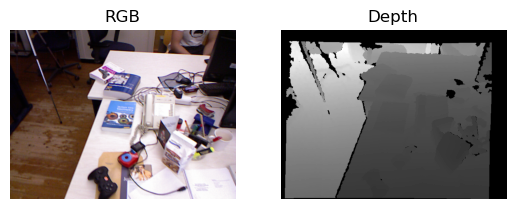

In [5]:
from torch.utils.data import DataLoader

data_loader = DataLoader(img_dataset, batch_size=1, shuffle=True)

# pick the first image from the dataloader
rgb, depth = next(iter(data_loader))

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(rgb[0])
plt.title('RGB')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(depth[0].squeeze(), cmap='gray')
plt.title('Depth')
plt.axis('off')
plt.show()